# Group Members

1. Sarah Shikanov, sarahshikanov@berkeley.edu
2. James Marquez, jamesamarquez@berkeley.edu
3. Michael Chien, mchien512@berkeley.edu
4. Rachel Fei, wfei@berkeley.edu

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import geopandas as gp

## Load in the Data

In [2]:
dem_df = pd.read_csv('dem_candidates.csv', encoding='latin1')
rep_df = pd.read_csv('rep_candidates.csv',encoding='latin-1')

In [3]:
poll_data = pd.read_csv('presidential_polls.csv')

### Dataset was taken from https://www.kaggle.com/fivethirtyeight/2016-election-polls


# 1.0 Data Overview

The democrat and republican data were generated by sampling. This was taken from the class dataset. At quick glance from the our pre processing step below we can see that in our first entry we have a governer running from office for Alabama. At quick glance we can see that the Partisan Lean is heavily negative which means its heavily red. This is consistent with what we would expect from before we began doing anything. We are not worried much about bias as this data is simply a representation of endorsements and the primary. Important features that would be useful if there was a way to get the total contribution with the candidate. We tried merging the dataframes with another dataset but it was very non trivial and thus decided to work with what we had. This dataset is public so all participants are aware of this dataset. As to the granularity each row represents a candidate running for office with endorsements and primary election data.

The 2016 Polling dataset was also generated by sampling. This was a dataset from Kaggle and we decided to use this because the election dataset given only covered endorsements and there weren't very many cool problems we could think of analyzing. Again by looking at the data we can get a quick glance at the polling advantages for each candidate and they seem to be consistent.The participants are aware of the collection and use of the data as it's published by pollsters. We can seUnlike the class dataset the polling dataset is worrisome with selection bias due to the unreliability of some pollsters but there is a column for grade which should help us identify good pollsters. The columns are sufficient in this dataset to perform what we want.

## 1.1 Preprocessing.

In [62]:
dem_df['Party'] = "Democrat"
rep_df['Party'] = 'Republican'

In [63]:
df = pd.concat([dem_df, rep_df])
df

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,Great America Endorsed?,NRA Endorsed?,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?
0,Anthony White (Alabama),AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Christopher Countryman,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Doug ""New Blue"" Smith",AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,James C. Fields,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Sue Bell Cobb,AL,Governor of Alabama,Governor,Regular,6/5/18,Lost,None,None,-28.879999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,Bill Dahlin,WY,Governor of Wyoming,Governor,Regular,8/21/18,Lost,None,None,NaN,...,NaN,NaN,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
770,Harriet Hageman,WY,Governor of Wyoming,Governor,Regular,8/21/18,Lost,None,None,NaN,...,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
771,Sam Galeotos,WY,Governor of Wyoming,Governor,Regular,8/21/18,Lost,None,None,NaN,...,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
772,Foster Friess,WY,Governor of Wyoming,Governor,Regular,8/21/18,Lost,None,None,NaN,...,NaN,NaN,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Democrats have weird NaN values for candidates who advanced as well as candidateas who lost so we drop these values 
# there are 22 of them.
# Repblicans have 0 so we don't have to do anything.
bad_indices = list(dem_df[(dem_df['Won Primary'].isna())].index)
dem_df = dem_df.drop(bad_indices);

In [7]:
# Treat a Nan Value as 0 and the encode no and yes as 0 and 1s.
df.fillna(0, inplace=True)
df.replace('No', 0, inplace=True)
df.replace('Yes', 1, inplace=True)

In [8]:
# Get a list of all democrat and republican endorsements
dem_endorsements = list(df.columns[13:32])
rep_endorsements = list(df.columns[33:46])
endorsements = dem_endorsements + rep_endorsements


# 2.0 EDA 

##  2.1 EDA on 2018 Primary Election Dataset

Lets begin with some EDA on our dataest with republicans and democrats from five thirty eight.

In [9]:
dem_endorsements

['Veteran?',
 'LGBTQ?',
 'Elected Official?',
 'Self-Funder?',
 'STEM?',
 'Obama Alum?',
 'Party Support?',
 'Emily Endorsed?',
 'Guns Sense Candidate?',
 'Biden Endorsed?',
 'Warren Endorsed? ',
 'Sanders Endorsed?',
 'Our Revolution Endorsed?',
 'Justice Dems Endorsed?',
 'PCCC Endorsed?',
 'Indivisible Endorsed?',
 'WFP Endorsed?',
 'VoteVets Endorsed?',
 'No Labels Support?']

We have a prior belief that some endorsements matter more than others. For example we take that Party Support should have a big impact on the number of votes one receives. In addition we think that big names such as Sanders and Biden.

In [10]:
dem_df.fillna(0, inplace=True)
dem_df.replace('No', 0, inplace=True)
dem_df.replace('Yes', 1, inplace=True)

In [11]:
dem_endorsements_df = dem_df[['Candidate'] + dem_endorsements + ['Won Primary']]
dem_endorsements_df

,Candidate,Veteran?,LGBTQ?,Elected Official?,Self-Funder?,STEM?,Obama Alum?,Party Support?,Emily Endorsed?,Guns Sense Candidate?,...,Warren Endorsed?,Sanders Endorsed?,Our Revolution Endorsed?,Justice Dems Endorsed?,PCCC Endorsed?,Indivisible Endorsed?,WFP Endorsed?,VoteVets Endorsed?,No Labels Support?,Won Primary
0,Anthony White (Alabama),1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Christopher Countryman,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Doug ""New Blue"" Smith",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,James C. Fields,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Sue Bell Cobb,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
806,Talley Sergent,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
807,Janice Hagerman,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
808,Paul Davis,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
809,Richard Ojeda,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1


In [12]:
dem_copy = dem_df.copy()
dem_copy = dem_df[['Party Support?', 'Biden Endorsed?', 'Sanders Endorsed?'] + ['Primary %']]
dem_copy

,Party Support?,Biden Endorsed?,Sanders Endorsed?,Primary %
0,0,0,0,3.420000
1,0,0,0,1.740000
2,0,0,0,3.270000
3,0,0,0,8.000000
4,0,0,0,28.980000
...,...,...,...,...
806,0,0,0,62.570000
807,0,0,0,7.240000
808,0,0,0,15.960000
809,0,0,0,52.160000


(39, 4)

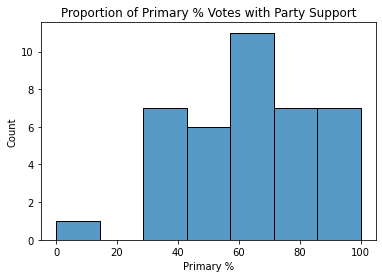

In [13]:
party_support = dem_copy[dem_copy['Party Support?'] == 1]
sns.histplot(party_support['Primary %'])
plt.title('Proportion of Primary % Votes with Party Support')
party_support.shape

(750, 4)

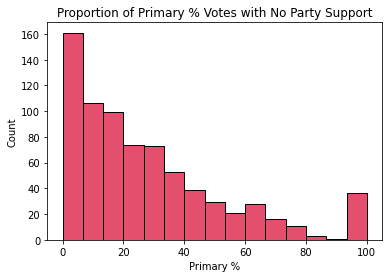

In [14]:
no_party_support = dem_copy[dem_copy['Party Support?'] == 0]
sns.histplot(no_party_support['Primary %'], color='crimson')
plt.title('Proportion of Primary % Votes with No Party Support')
no_party_support.shape

From here we can see that party support is quite important. The histogram with no party support is right skewed wit many of the votes not even above 50%. Out of 750 candidates there is a few percentage that is above 50% compared to the first histogram. We should keep this in mind when building our model. 

Let's see if we can get a good view of partisan lean based on the state.

In [26]:
df_copy = df.copy()
df_copy = df[['Partisan Lean', 'State']]
df_copy = df_copy.groupby(by=['State']).mean()
df_copy.reset_index().head(5)

,State,Partisan Lean
0,AK,0.000000
1,AL,-36.023125
2,AR,-23.818889
3,AZ,-1.637333
4,CA,-0.819133


In [27]:
map_us.head(5)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,region,geometry
0,06,01779778,0400000US06,06,CA,California,00,403483823181,20483271881,West,"MULTIPOLYGON Z (((-118.59397 33.46720 0.00000,..."
1,11,01702382,0400000US11,11,DC,District of Columbia,00,158350578,18633500,Northeast,"POLYGON Z ((-77.11976 38.93434 0.00000, -77.04..."
2,12,00294478,0400000US12,12,FL,Florida,00,138903200855,31407883551,Southeast,"MULTIPOLYGON Z (((-81.81169 24.56874 0.00000, ..."
3,13,01705317,0400000US13,13,GA,Georgia,00,148963503399,4947080103,Southeast,"POLYGON Z ((-85.60516 34.98468 0.00000, -85.47..."
4,16,01779783,0400000US16,16,ID,Idaho,00,214045425549,2397728105,West,"POLYGON Z ((-117.24303 44.39097 0.00000, -117...."


In [28]:
map_us = gp.read_file('usa-states-census-2014.shp')
map_us.dtypes

STATEFP       object
STATENS       object
AFFGEOID      object
GEOID         object
STUSPS        object
NAME          object
LSAD          object
ALAND          int64
AWATER         int64
region        object
geometry    geometry
dtype: object

In [31]:
map_us.join(df_copy)

bad_states = ['Commonwealth of the Northern Mariana Islands', 'Guam', 'United States Virgin Islands', 
              'American Samoa', 'Puerto Rico', 'District of Columbia']

map_us_copy = map_us.copy()
map_us_copy = map_us[~map_us.NAME.isin(bad_states)]
map_us_copy = map_us_copy.sort_values(by='NAME')
new_map = pd.merge(map_us_copy, df_copy, left_on='STUSPS', right_on='State')

In [37]:
new_map = new_map.to_crs('EPSG:3395',);

In [40]:
new_map = new_map.round({'Partisan Lean': 2})

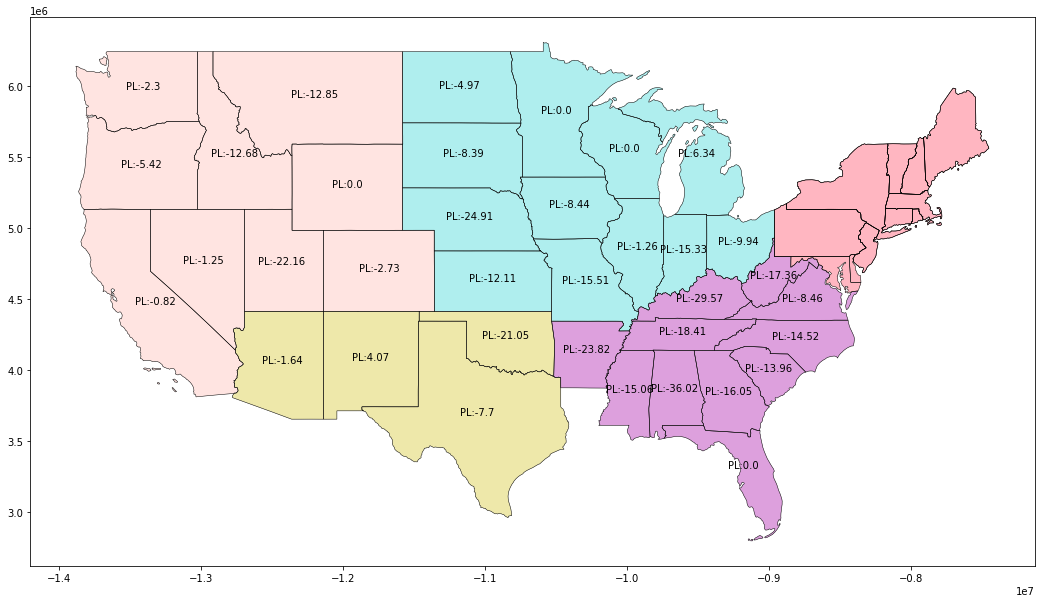

In [41]:
# Code adpated from https://jcutrer.com/python/learn-geopandas-plotting-usmaps
ax = new_map.boundary.plot(figsize=(18, 12), color='Black', linewidth=.5)
west = new_map[new_map['region'] == 'West']
southwest = new_map[new_map['region'] == 'Southwest']
southeast = new_map[new_map['region'] == 'Southeast']
midwest = new_map[new_map['region'] == 'Midwest']
northeast = new_map[new_map['region'] == 'Northeast']

west.apply(
    lambda x: ax.annotate(
        text="PL:" + str(x['Partisan Lean']), 
        xy= (x.geometry.centroid.coords[0]),
        ha='center', 
        color='#000000', 
        fontsize=10),axis=1);

southwest.apply(
    lambda x: ax.annotate(
        text="PL:" + str(x['Partisan Lean']), 
        xy= (x.geometry.centroid.coords[0]),
        ha='center', 
        color='#000000', 
        fontsize=10),axis=1);

southeast.apply(
    lambda x: ax.annotate(
        text="PL:" + str(x['Partisan Lean']), 
        xy= (x.geometry.centroid.coords[0]),
        ha='center', 
        color='#000000', 
        fontsize=10),axis=1);

midwest.apply(
    lambda x: ax.annotate(
        text="PL:" + str(x['Partisan Lean']), 
        xy= (x.geometry.centroid.coords[0]),
        ha='center', 
        color='#000000', 
        fontsize=10),axis=1);

west.plot(ax=ax,  color="MistyRose")
southwest.plot(ax=ax, color="PaleGoldenRod")
southeast.plot(ax=ax, color="Plum")
midwest.plot(ax=ax, color="PaleTurquoise")
final_map = northeast.plot(ax=ax, color="LightPink")



This map is a useful visualization of the partisan leans betwen states. We see that the South is heavily republican while the West is less repbulican and leaning torwards more Democrat. This is quite as expected but can be useful when performing Bayesian Inference.

<AxesSubplot:>

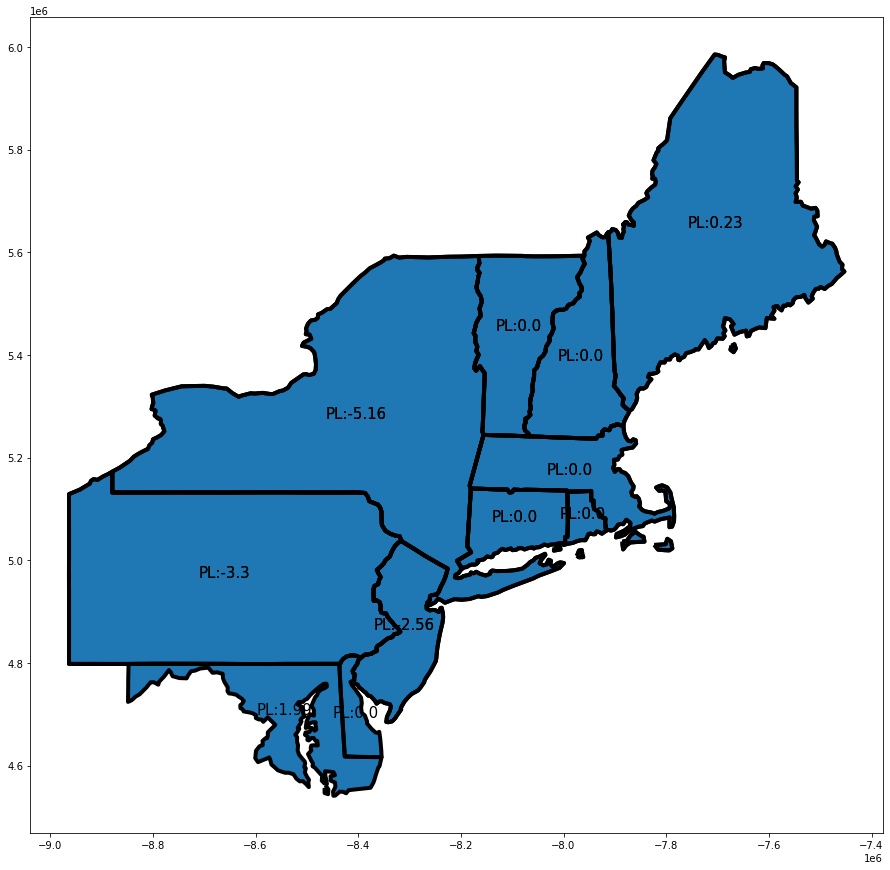

In [43]:
fig = plt.figure(1, figsize=(25,15)) 
ax = fig.add_subplot()
northeast = new_map[new_map['region'] == 'Northeast']
northeast.apply(
    lambda x: ax.annotate(
        text="PL:" + str(x['Partisan Lean']), 
        xy= (x.geometry.centroid.coords[0]),
        ha='center', 
        color='#000000', # blue
        fontsize=15),axis=1);
northeast.boundary.plot(ax=ax, color ='Black', linewidth=4)
northeast.plot(figsize=(10, 10), ax = ax)


As expected with our prior beliefs the northeast seems to have a partisan lean more torwards Democrats!

# 3.0 Nonparameteric Methods/GLMs.


**Can we predict if a candidate won the primary based on the number of endorsements/type of endorsement**

1. GLM : Logistic Regression because we have a binary decision.
2. Nonparametric Methods: DecisionTree/RandomForest because it again works well with binary decisions and our data should be easily seperable.

## 3.1 Nonparametric Methods.

### 3.1.1 Train Test Split

We will conduct a train test split with 70% of the data being in our training set.

In [51]:
# Train test split random seed 102
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, train_size = 0.7, test_size = 0.3, random_state=10) 

### 3.1.2 Feature Engineering

1. We wil create a column of unique endorsements based on the number of endorsements from republicans and democrats.
2. Next we will calculate the proportion of endorsements based on party.

In [52]:
# Sum over all rows and find the number of unique endorsements.
train.loc[:,'Unique Endorsements'] = train[endorsements].sum(axis = 1)
test.loc[:, 'Unique Endorsements'] = test[endorsements].sum(axis = 1)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [53]:
train.sample(n= 5)

,Candidate,State,District,Office Type,Race Type,Race Primary Election Date,Primary Status,Primary Runoff Status,General Status,Partisan Lean,...,NRA Endorsed?,Right to Life Endorsed?,Susan B. Anthony Endorsed?,Club for Growth Endorsed?,Koch Support?,House Freedom Support?,Tea Party Endorsed?,Main Street Endorsed?,Chamber Endorsed?,Unique Endorsements
152,Paulette E. Jordan,ID,Governor of Idaho,Governor,Regular,5/15/18,Advanced,None,On the Ballot,-34.330002,...,0,0,0,0,0,0,0,0,0,3
726,Pedro Valencia,TX,U.S. House Texas District 29,Representative,Regular,3/6/18,Lost,None,None,39.970001,...,0,0,0,0,0,0,0,0,0,0
459,Omar Vaid,NY,U.S. House New York District 11,Representative,Regular,6/26/18,Lost,None,None,-8.810000,...,0,0,0,0,0,0,0,0,0,0
286,Janet T. Mills,ME,Governor of Maine,Governor,Regular,6/12/18,Advanced,None,On the Ballot,3.510000,...,0,0,0,0,0,0,0,0,0,2
362,David Wilson Brown,NC,U.S. House North Carolina District 10,Representative,Regular,5/8/18,Advanced,None,On the Ballot,-25.510000,...,0,0,0,0,0,0,0,0,0,1


In [54]:
def calculate_proportion(row):
    if (row['Party'] == 'Democrat'):
        row['Proportion'] = row['Unique Endorsements']/len(dem_endorsements)
    else:
        row['Proportion'] = row['Unique Endorsements']/len(rep_endorsements)
    return row

In [55]:
train = train.apply(lambda row:  calculate_proportion(row), axis = 1)
test = test.apply(lambda row: calculate_proportion(row), axis = 1)

In [56]:
X = train[['Partisan Lean', 'Unique Endorsements', 'Proportion', 'Party Support?']]
y = train['Won Primary']

### 3.1.3 Nonparametric Methods Results.

In [182]:
from sklearn.linear_model import LogisticRegression as LR

model = LR()
model.fit(X, y)
y_pred = model.predict(X)
y_pred_test = model.predict(test[['Partisan Lean', 'Unique Endorsements', 'Proportion', 'Party Support?']])

train['pred'] = y_pred
test['pred'] = y_pred_test


from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['pred'], train['Won Primary'])
test_accuracy = accuracy_score(test['pred'], test['Won Primary'])
train_accuracy, test_accuracy



(0.7376014427412083, 0.7016806722689075)

We don't have the best accuracy using logistic regression lets see if we can do better with random forest and perhaps our data is not very linearly seperable.

In [183]:
# These are the columns we will use in our model.
X_col = ['Partisan Lean', 'Unique Endorsements', 'Proportion', 'Party Support?']
y_col = 'Won Primary'

In [184]:
# Predict and add these predictions to our dataframe
from sklearn.ensemble import RandomForestClassifier


tree_model = RandomForestClassifier()
X = train[X_col]
y = train[y_col]
tree_model.fit(X,y)
y_pred = tree_model.predict(X)
y_pred_test = tree_model.predict(test[X_col])

train['tree_pred'] = y_pred
test['tree_pred'] = y_pred_test

from sklearn.metrics import accuracy_score

train_accuracy = accuracy_score(train['tree_pred'], train['Won Primary'])
test_accuracy = accuracy_score(test['tree_pred'], test['Won Primary'])
train_accuracy, test_accuracy

(0.8151487826871056, 0.6932773109243697)



We will look at our mean squared error.

### 3.1.4 Interpretation of results

For our first model logistic regression seemed to have trouble linearly seperating the data thus resulting in around 70% accuracy. It 

It seems that our training accuracy is not the most acurate at 81% training accuracy. Our test accuracy is even lower and this is most likely due to the fact that we are overfitting our data therefore compromising something in our model. To fix this, better feature selection/feature engineering can help overfitting and will be something to look at to fix for our final project. 

## 3.2 GLM Model

Next we will look at using a GLM logistic regresion model. We will approach this using a frequentist appraoch then look at it from a bayesian approach.

In [225]:
from scipy.stats import poisson, norm, gamma
import statsmodels.api as sm

try:
    from pymc3 import *
    import pymc3 as pm
except:
    ! pip install pymc3
    from pymc3 import *
    import pymc3 as pm

In [57]:
# Some glm preprocessing 
glm_df = train.copy()
glm_df['Unique Endorsements'] = glm_df[endorsements].sum(axis = 1)

## 3.2.1 Methods

Again we are trying to predict the same thing as above in our nonparameric methods. We will be using a binomial glm because we have count data and our link function should work for our binary data.  We will then evaluate the model by first using a frequentist model and analyzing the deviance and Pearson chi-squared before than analyzing the posterior distribution.

## 3.2.2 Results

In [18]:
# Frequentist GLM
glm_binom = sm.GLM(glm_df['Won Primary'], exog=sm.add_constant(glm_df[X_col]), 
                   family=sm.families.Binomial())
glm_res = glm_binom.fit()
print(glm_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:            Won Primary   No. Observations:                 1109
Model:                            GLM   Df Residuals:                     1105
Model Family:                Binomial   Df Model:                            3
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -637.71
Date:                Thu, 09 Dec 2021   Deviance:                       1275.4
Time:                        15:02:35   Pearson chi2:                 1.11e+03
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -1.3622    

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [19]:
glm_df = glm_df.rename(columns={'Won Primary' : 'Won_Primary', 'Unique Endorsements' : 'Unique_Endorsements', 
                               'Partisan Lean': 'Partisan_Lean'})

In [20]:
# Bayesian GLM
with pm.Model() as bayes_model:
    glm.GLM.from_formula("Won_Primary ~ + Unique_Endorsements + Partisan_Lean + Proportion", glm_df, 
                         family = glm.families.Binomial())
    trace_binomial = pm.sample(1000, cores = 1, target_accept = 0.95, init='adapt_diag')

/tmp/ipykernel_24/536276188.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_binomial = pm.sample(1000, cores = 1, target_accept = 0.95, init='adapt_diag')
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [Proportion, Partisan_Lean, Unique_Endorsements, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 89 seconds.


In [21]:
pm.summary(trace_binomial)

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.371,0.095,-1.562,-1.207,0.003,0.002,1027.0,1008.0,1.0
Unique_Endorsements,-0.576,0.256,-1.002,-0.073,0.009,0.006,800.0,831.0,1.0
Partisan_Lean,-0.015,0.004,-0.023,-0.007,0.000,0.000,969.0,983.0,1.0
Proportion,16.953,4.430,8.326,24.704,0.158,0.113,780.0,775.0,1.0


Got error No model on context stack. trying to find log_likelihood in translation.
/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'Unique_Endorsements'}>,
        <AxesSubplot:title={'center':'Unique_Endorsements'}>],
       [<AxesSubplot:title={'center':'Partisan_Lean'}>,
        <AxesSubplot:title={'center':'Partisan_Lean'}>],
       [<AxesSubplot:title={'center':'Proportion'}>,
        <AxesSubplot:title={'center':'Proportion'}>]], dtype=object)

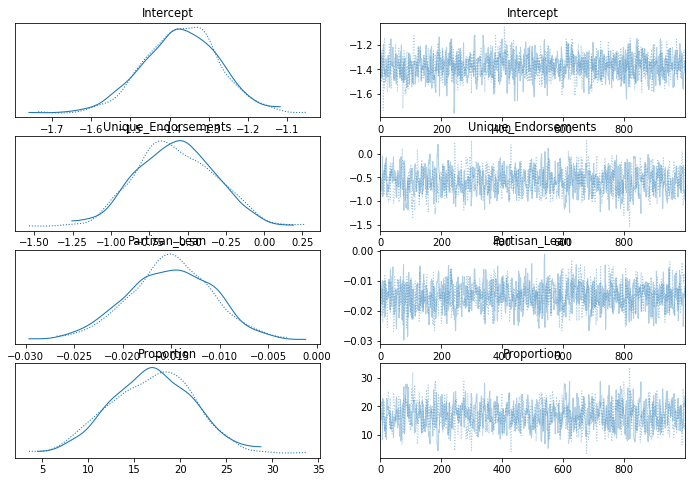

In [22]:
az.plot_trace(trace_binomial)

We can also plot the posterior distributions and see their credible intervals.

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'Unique_Endorsements'}>,
       <AxesSubplot:title={'center':'Partisan_Lean'}>,
       <AxesSubplot:title={'center':'Proportion'}>], dtype=object)

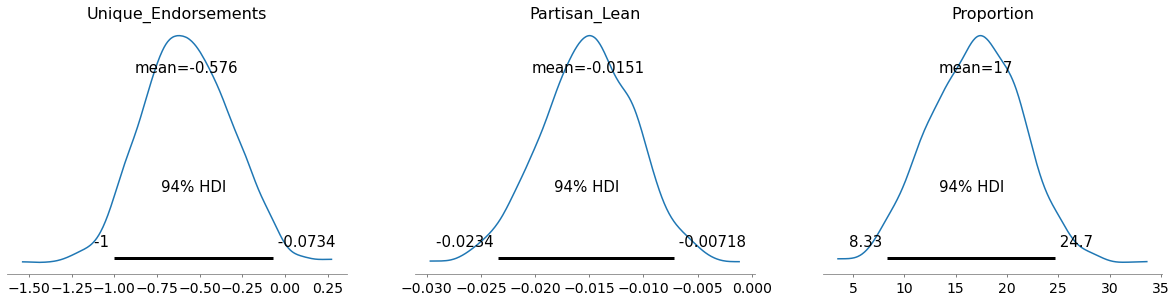

In [23]:
# Plot Posterior
az.plot_posterior(trace_binomial, ['Unique_Endorsements', 'Partisan_Lean', 'Proportion'], round_to=3)

In [61]:
glm_df['Unique Endorsements'].mean(), glm_df['Partisan Lean'].mean(), glm_df['Proportion'].mean()

(0.8917944093778178, -7.363444505509468, 0.05204017187311762)

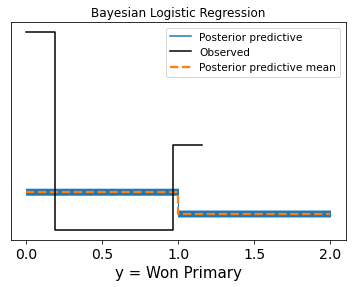

In [24]:
# Bayesian Posterior Predictive Check
# THERE ARE SOME ISSUES HERE IDK WHY
with bayes_model:
    binomial_ppc = pm.sample_posterior_predictive(trace_binomial)
    ppc_binomial = az.from_pymc3(trace_binomial, posterior_predictive=binomial_ppc)
    
az.plot_ppc(ppc_binomial)
plt.xlabel('y = Won Primary')
plt.title('Bayesian Logistic Regression')
plt.show()

### 3.2.3 Results  for GLM and Comparison to Random Forest


For our frequentist model we see we have a very negative log likelihood which may seem that this is not a good fit for our model. However if we look at the number of observations minus the number of parameters $n-p = 1109 - 5 = 1104$. Our deviance and chi-square $\chi^2$ is $1275$ and $1100$ respectively because these are not too off our frequentist model does not seem to be a very good fit. 

Comparing to our nonparametric method of random forest we found we had a not terrible training accuracy but not very good test accuracy. We conclucded this must be because of overfitting. However our GLM shows that indeed our model has some problems with our frequentist as well as our bayesian model using posterior predictive checks.

In [38]:
poll_data = pd.read_csv('presidential_polls.csv')

In [64]:
poll_data.head(2)

,startdate,enddate,state,pollster,grade,poll_wt,samplesize,population,adjpoll_clinton,adjpoll_trump
0,2016-10-25,2016-10-31,U.S.,Google Consumer Surveys,B,6.139129,24316.0,lv,42.64140,40.86509
1,2016-10-27,2016-10-30,U.S.,ABC News/Washington Post,A+,4.197292,1128.0,lv,43.29659,44.72984


In [40]:
poll_data.columns

Index(['cycle', 'branch', 'type', 'matchup', 'forecastdate', 'state',
       'startdate', 'enddate', 'pollster', 'grade', 'samplesize', 'population',
       'poll_wt', 'rawpoll_clinton', 'rawpoll_trump', 'rawpoll_johnson',
       'rawpoll_mcmullin', 'adjpoll_clinton', 'adjpoll_trump',
       'adjpoll_johnson', 'adjpoll_mcmullin', 'multiversions', 'url',
       'poll_id', 'question_id', 'createddate', 'timestamp'],
      dtype='object')

## 4.0 EDA on Polling Data from Kaggle.

We will begin with some EDA to visualzie if we can identify key features or plot data to help form good priors.

### Dataset was taken from https://www.kaggle.com/fivethirtyeight/2016-election-polls


In [68]:
poll_data = pd.read_csv('presidential_polls.csv')

In [69]:
poll_data.head(2)

,cycle,branch,type,matchup,forecastdate,state,startdate,enddate,pollster,grade,...,adjpoll_clinton,adjpoll_trump,adjpoll_johnson,adjpoll_mcmullin,multiversions,url,poll_id,question_id,createddate,timestamp
0,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/25/2016,10/31/2016,Google Consumer Surveys,B,...,42.64140,40.86509,5.675099,NaN,NaN,https://datastudio.google.com/u/0/#/org//repor...,47940,74999,11/1/16,15:09:38 1 Nov 2016
1,2016,President,polls-plus,Clinton vs. Trump vs. Johnson,11/1/16,U.S.,10/27/2016,10/30/2016,ABC News/Washington Post,A+,...,43.29659,44.72984,3.401513,NaN,NaN,http://www.langerresearch.com/wp-content/uploa...,47881,74936,11/1/16,15:09:38 1 Nov 2016


In [70]:
poll_data.columns

Index(['cycle', 'branch', 'type', 'matchup', 'forecastdate', 'state',
       'startdate', 'enddate', 'pollster', 'grade', 'samplesize', 'population',
       'poll_wt', 'rawpoll_clinton', 'rawpoll_trump', 'rawpoll_johnson',
       'rawpoll_mcmullin', 'adjpoll_clinton', 'adjpoll_trump',
       'adjpoll_johnson', 'adjpoll_mcmullin', 'multiversions', 'url',
       'poll_id', 'question_id', 'createddate', 'timestamp'],
      dtype='object')

In [71]:
poll_data = poll_data[["startdate", "enddate", "state", "pollster", "grade", 'poll_wt',
  "samplesize", "population", "adjpoll_clinton", "adjpoll_trump"]]


poll_data['startdate'] = pd.to_datetime(poll_data["startdate"])
poll_data["enddate"] = pd.to_datetime(poll_data["enddate"])
poll_data.sort_values(by=['startdate', 'enddate'])

,startdate,enddate,state,pollster,grade,poll_wt,samplesize,population,adjpoll_clinton,adjpoll_trump
3071,2015-11-06,2015-11-16,New Hampshire,Morning Consult,NaN,6.120000e-06,530.0,rv,45.40125,38.46687
6517,2015-11-06,2015-11-16,New Hampshire,Morning Consult,NaN,7.660000e-07,530.0,rv,45.20979,38.59373
9895,2015-11-06,2015-11-16,New Hampshire,Morning Consult,NaN,6.120000e-06,530.0,rv,45.39273,38.40193
3077,2015-11-07,2015-11-08,South Carolina,Public Policy Polling,B+,5.460000e-06,1290.0,v,40.63694,45.19826
6520,2015-11-07,2015-11-08,South Carolina,Public Policy Polling,B+,6.710000e-07,1290.0,v,40.48820,45.19637
...,...,...,...,...,...,...,...,...,...,...
6864,2016-10-30,2016-10-30,Virginia,Remington,NaN,2.282895e+00,1106.0,lv,46.66191,41.12267
6872,2016-10-30,2016-10-30,Florida,Remington,NaN,2.171098e+00,989.0,lv,43.66191,46.12267
6881,2016-10-30,2016-10-30,Colorado,Remington,NaN,2.132726e+00,952.0,lv,44.66191,42.12267
6905,2016-10-30,2016-10-30,Nevada,Remington,NaN,1.940524e+00,787.0,lv,43.66191,46.12267


Next we will identify battleground states based on the difference between the adjusted poll values between Trump and Clinton. If the difference between clinton and the trump poll fall below a value $\epsilon$ we will define this as a battleground state.

In [72]:
df = poll_data.copy()

In [73]:
57.9 + 33

90.9

In [74]:
df_group = df.groupby(by=['state']).mean().reset_index()
df_group.head(5)

,state,poll_wt,samplesize,adjpoll_clinton,adjpoll_trump
0,Alabama,0.106648,608.968750,32.570923,57.944145
1,Alaska,0.263570,319.310345,35.678765,43.713035
2,Arizona,0.305452,760.866667,41.697958,43.768535
3,Arkansas,0.143535,335.882353,37.011808,50.654389
4,California,0.224925,1275.036364,54.934097,32.294801


In [75]:
def battleground(row, eps=2):
    if abs(row['adjpoll_clinton'] - row['adjpoll_trump']) < eps:
        row['battleground'] = 1
    else:
        row['battleground'] = 0
    return row

In [76]:
df_group = df_group.apply(lambda row: battleground(row), axis = 1)

In [77]:
battleground_states = df_group[df_group['battleground'] == 1]['state']

df[df['state'].isin(battleground_states.tolist())]
battleground_states

9            Florida
15              Iowa
33            Nevada
38    North Carolina
40              Ohio
Name: state, dtype: object

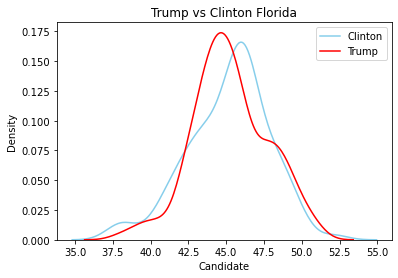

In [78]:
# Look at florida 
fig, ax = plt.subplots()
sns.kdeplot(df[df['state'] == 'Florida']['adjpoll_clinton'], ax = ax, color='skyblue', label='Clinton')
sns.kdeplot(df[df['state'] == 'Florida']['adjpoll_trump'], ax = ax, color = 'red', label='Trump')
plt.xlabel("Candidate")
plt.title("Trump vs Clinton Florida") 
plt.legend()



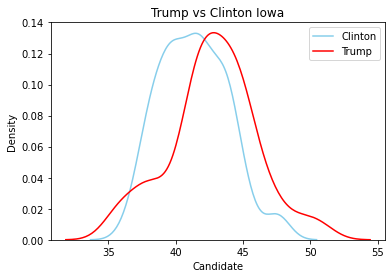

In [79]:
fig, ax = plt.subplots()
sns.kdeplot(df[df['state'] == 'Iowa']['adjpoll_clinton'], ax = ax, color='skyblue', label='Clinton')
sns.kdeplot(df[df['state'] == 'Iowa']['adjpoll_trump'], ax = ax, color = 'red', label='Trump')
plt.xlabel('Candidate')
plt.title('Trump vs Clinton Iowa')
plt.legend()

We can see for battleground states even though a state has a higher mode such as Clinton in Florida, Trump in the polls still has the lead as his avergae poll rating is higher. This is most likely due to that Trump has a higher density in Florida giving him a slight lead. Most of the differences come from the distributions being slightly wider or taller in key areas.

Lets introduce a new variable adjusted lead which will be the difference between Clinton and Trump poll ratings where a positive value means Clinton has a lead over trump and negative means Trump has the lead over Clinton.  

In [80]:
df['adj_lead'] = df['adjpoll_clinton'] - df['adjpoll_trump']

df['adj_lead'].mean(), df['adj_lead'].var()

(0.9762825313599062, 153.4731635576654)

<AxesSubplot:xlabel='adj_lead', ylabel='Density'>

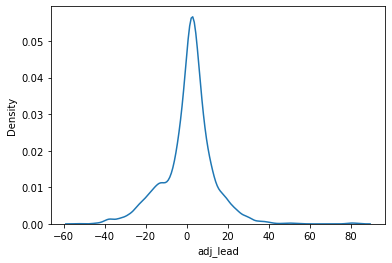

In [81]:
sns.kdeplot(df['adj_lead'])

We are trying to construct a prior belief on our estimate for the adjusted lead of the candidate. We will assume that our likelihood follows a normal distribution. 

From here we can see the partisan leans for each state and which ones are leaning red or blue. We can see heavy republican leans on the southeast while on the west it seems that leans are much 

# 5.0 Bayesian Hierarchial Modeling

### Our resarch question will be dealing with trying to estimate the poll leads between Clinton and Trump during the 2016 presidential election. Dataset was taken from https://www.kaggle.com/fivethirtyeight/2016-election-polls


## 5.1 Building a Basic Model/Methods 


Our graphical model is as follows whre we have our parameter where we have this as our prior belief based on our estimates above. 

$\mu \sim Uniform(-40, 40)$

$\sigma^2 \sim HalfNormal(0, 5)$

$X \mid (\mu, \sigma^2) \sim  \mathcal{N}(\mu, \sigma^2)$

We choose $\mu$ and $\sigma^2$ as these priors because we see that most of the values fall between -60 and 60. Finally the variance cannot be negative and the we have a tight distribution so we choose a smaller variance so we choose a half normal.



In [82]:
import pymc3 as pm

In [83]:
with pm.Model() as model:
    μ = pm.Uniform('μ', lower=-60, upper=60)
    σ = pm.HalfNormal('σ', sd=5)
    X = pm.Normal('X', mu=μ, sd=σ, observed=df['adj_lead'].values)
    trace_guassian = pm.sample(1000, tune=1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


## 5.2 Results

array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

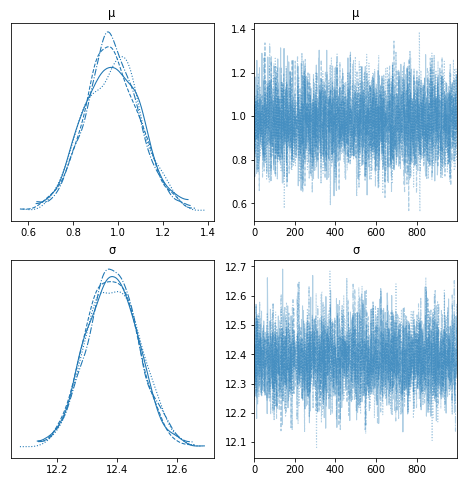

In [85]:
import arviz as az


f, axs = plt.subplots(2,2,figsize=(8,8))


az.plot_trace(trace_guassian, axes = axs)

Our trace plots look good here. Our values on the left seem to have converged and be stationary and our MAP estimate which is the peak on the left graphs seem to be relatively close to the true value. Lets look at the joint trace of our sample.

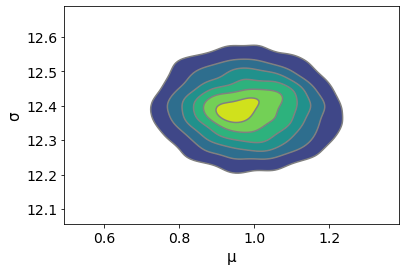

In [21]:
az.plot_pair(trace_guassian, kind='kde', fill_last=False);

We can see here that our values do not seem to be correlated with each other which is a good thing. Now lets see if we can categorize the states into groups.

## 5.3 Adding Regions to our Model 

Lets consider adding the four regions to our model and consider how this changes our model.  

In [20]:
ne = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 
      'Vermont','New Jersey', 'New York', 'Pennsylvania', 'Maine CD-1', 'Maine CD-2']

mw = ['Illinois','Indiana','Michigan','Ohio', 'Wisconsin','Iowa', 'Kansas', 'Minnesota', 'Missouri', 
      'Nebraska', 'North Dakota', 'South Dakota','Nebraska CD-2', 'Nebraska CD-3', 'Nebraska CD-1']

so= ['Delaware', 'Florida', 'Georgia', 'Maryland', 'North Carolina',
     'South Carolina', 'Virginia', 'District of Columbia', 'West Virginia',
    'Alabama', 'Kentucky', 'Mississippi','Tennessee','Arkansas', 'Louisiana', 'Oklahoma', 'Texas']

we = ['Arizona', 'Colorado', 'Idaho', 'Montana', 'Nevada', 'New Mexico', 'Utah', 'Wyoming',
     'Alaska', 'California', 'Hawaii', 'Oregon', 'Washington']

In [97]:
# U.S randomly considred a state.
df_2 = df.copy()
df_2 = df[df['state'] != 'U.S.']


In [99]:
# Adds a region column to each row which is encoded.
def add_region(row):
    if row['state'] in ne: 
        row['region'] = 0
    elif row['state'] in mw:
        row['region'] = 1
    elif row['state'] in so:
        row['region'] = 2
    elif row['state'] in we:
        row['region'] = 3
    return row

In [98]:
# Apply our function we created above.
df_2 = df_2.apply(lambda row: add_region(row), axis= 1)

In [100]:
# Create a index to use in our model.
idx = pd.Categorical(df_2['region'], 
                   categories=[0, 1, 2, 3]).codes

## 5.4 Results of More Robust Model

In [32]:
with pm.Model() as model_regions:
    μ = pm.Uniform('μ', lower=-60, upper=60,shape= 4)
    σ = pm.HalfNormal('σ', sd=5,shape=4)
    X = pm.Normal('X', mu=μ[idx], sd=σ[idx], observed=df_2['adj_lead'].values)
    trace_guassian_regions = pm.sample(1000, tune=1000, return_inferencedata=False, cores = 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [σ, μ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.


In [34]:
az.summary(az.from_pymc3(trace_guassian_regions))

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],10.408,0.268,9.906,10.878,0.005,0.003,3228.0,1453.0,1.0
μ[1],-2.038,0.268,-2.507,-1.498,0.005,0.004,2580.0,1183.0,1.0
μ[2],-5.155,0.318,-5.752,-4.557,0.006,0.004,2828.0,1611.0,1.0
μ[3],0.661,0.377,-0.083,1.352,0.006,0.005,3789.0,1608.0,1.0
σ[0],9.759,0.186,9.406,10.084,0.004,0.002,2790.0,1768.0,1.0
σ[1],11.088,0.188,10.749,11.456,0.003,0.002,4227.0,1657.0,1.0
σ[2],15.646,0.227,15.194,16.050,0.004,0.003,3370.0,1694.0,1.0
σ[3],14.614,0.249,14.189,15.110,0.004,0.003,3630.0,1770.0,1.0


From this summary table we can see that there is quite a different in regions. For example the north east seems to have a big lead torwards Hilary Clinton while the midwest and south favor Trump much more. 

Got error No model on context stack. trying to find log_likelihood in translation.
/opt/conda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>],
       [<AxesSubplot:title={'center':'σ'}>,
        <AxesSubplot:title={'center':'σ'}>]], dtype=object)

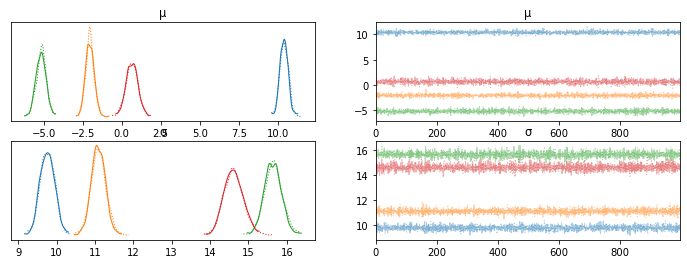

In [77]:
az.plot_trace(trace_guassian_regions)

In [78]:
df_2.groupby('region').mean()

,samplesize,adjpoll_clinton,adjpoll_trump,adj_lead
region,,,,
0,634.572368,47.855455,37.453344,10.402111
1,714.257391,40.852794,42.884180,-2.031386
2,675.943750,41.185942,46.355735,-5.169793
3,606.754128,41.262549,40.590502,0.672047


We see that our model does a good job of being accurate in estimating the means between region. Lets next run a posterior predictive check as model checking is always good. 

In [82]:
ppc = pm.sample_posterior_predictive(trace_guassian_regions, samples=2000, model=model_regions)


In [84]:
np.asarray(ppc['X']).shape

(2000, 7131)

Text(0.5, 1.0, 'Posterior Predictive Means')

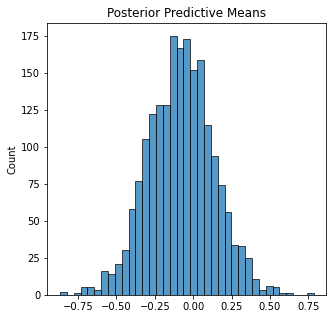

In [91]:
means = [X.mean() for X in ppc['X']]
ax = plt.subplots(figsize=(5, 5))
sns.histplot(means)
plt.title('Posterior Predictive Means')

Lets overlay a line of the true mean.

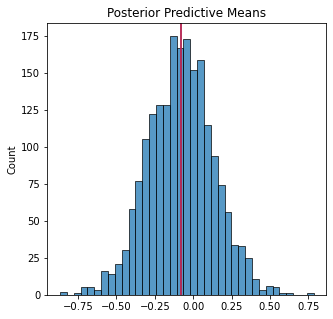

In [96]:
means = [X.mean() for X in ppc['X']]
ax = plt.subplots(figsize=(5, 5))
sns.histplot(means)
plt.title('Posterior Predictive Means')
ax[1].axvline(df_2['adj_lead'].mean())
plt.axvline(df_2['adj_lead'].mean(), color='crimson')

We see here that our model does a good job of approximating the mean!

## 5.4 Discussion

We began with a simple model where we used our prior beliefs and guassian likelihood functio to approximate the adjust lead which was the difference between the Trump and Clinton poll. We then tried a more robust graphical model where introduced regions and from there saw differences in adjusted leads based on the region. I tried to incorporate poll weight into our graphical model but ran into trouble as I didn't know how the likelihood would cange or maybe the prior I chose for the poll weight was incorrect. This is one of the issues with Bayesian Inference is that you don't quite know how to choose a prior which was the issue I ran into. Some data that would be interesting to look at were the demographics in each region such as gender, race, etc.